## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-01-22 15:59:58--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.248.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.248.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  62.3MB/s    in 4.9s    

2021-01-22 16:00:03 (65.4 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.25)
  (drop4): Dropout(p=0.3)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

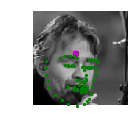

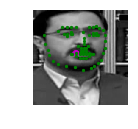

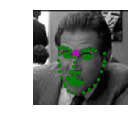

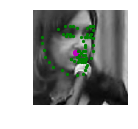

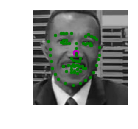

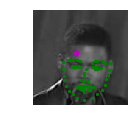

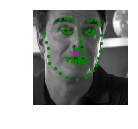

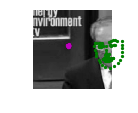

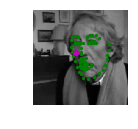

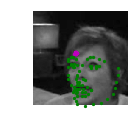

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.5345409333705902
Epoch: 1, Batch: 20, Avg. Loss: 0.20709963589906694
Epoch: 1, Batch: 30, Avg. Loss: 0.17928509414196014
Epoch: 1, Batch: 40, Avg. Loss: 0.23837590962648392
Epoch: 1, Batch: 50, Avg. Loss: 0.2196280486881733
Epoch: 1, Batch: 60, Avg. Loss: 0.17781926468014717
Epoch: 1, Batch: 70, Avg. Loss: 0.17915937379002572
Epoch: 1, Batch: 80, Avg. Loss: 0.2261424519121647
Epoch: 1, Batch: 90, Avg. Loss: 0.16559639796614647
Epoch: 1, Batch: 100, Avg. Loss: 0.17735498622059823
Epoch: 1, Batch: 110, Avg. Loss: 0.1849368095397949
Epoch: 1, Batch: 120, Avg. Loss: 0.23601887598633767
Epoch: 1, Batch: 130, Avg. Loss: 0.1932367615401745
Epoch: 1, Batch: 140, Avg. Loss: 0.16767192035913467
Epoch: 1, Batch: 150, Avg. Loss: 0.21966496407985686
Epoch: 1, Batch: 160, Avg. Loss: 0.1887345090508461
Epoch: 1, Batch: 170, Avg. Loss: 0.17866224721074103
Epoch: 1, Batch: 180, Avg. Loss: 0.2321060463786125
Epoch: 1, Batch: 190, Avg. Loss: 0.17209337279200554
Epoch: 1,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.1422245368361473
Epoch: 2, Batch: 20, Avg. Loss: 0.11768689900636672
Epoch: 2, Batch: 30, Avg. Loss: 0.17254964411258697
Epoch: 2, Batch: 40, Avg. Loss: 0.1601895846426487
Epoch: 2, Batch: 50, Avg. Loss: 0.14548467993736267
Epoch: 2, Batch: 60, Avg. Loss: 0.15180796161293983
Epoch: 2, Batch: 70, Avg. Loss: 0.160934479534626
Epoch: 2, Batch: 80, Avg. Loss: 0.1416657641530037
Epoch: 2, Batch: 90, Avg. Loss: 0.13848667368292808
Epoch: 2, Batch: 100, Avg. Loss: 0.19408057481050492
Epoch: 2, Batch: 110, Avg. Loss: 0.15257533192634581
Epoch: 2, Batch: 120, Avg. Loss: 0.1686824381351471
Epoch: 2, Batch: 130, Avg. Loss: 0.1437355950474739
Epoch: 2, Batch: 140, Avg. Loss: 0.13733718395233155
Epoch: 2, Batch: 150, Avg. Loss: 0.13247975558042527
Epoch: 2, Batch: 160, Avg. Loss: 0.17405373156070708
Epoch: 2, Batch: 170, Avg. Loss: 0.1390140786767006
Epoch: 2, Batch: 180, Avg. Loss: 0.2326809424906969
Epoch: 2, Batch: 190, Avg. Loss: 0.12710136733949184
Epoch: 2, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.14798055738210678
Epoch: 3, Batch: 20, Avg. Loss: 0.18040733262896538
Epoch: 3, Batch: 30, Avg. Loss: 0.1863800950348377
Epoch: 3, Batch: 40, Avg. Loss: 0.11835607811808586
Epoch: 3, Batch: 50, Avg. Loss: 0.13631817921996117
Epoch: 3, Batch: 60, Avg. Loss: 0.17254311144351958
Epoch: 3, Batch: 70, Avg. Loss: 0.11109076365828514
Epoch: 3, Batch: 80, Avg. Loss: 0.1065916508436203
Epoch: 3, Batch: 90, Avg. Loss: 0.20105091370642186
Epoch: 3, Batch: 100, Avg. Loss: 0.16249277740716933
Epoch: 3, Batch: 110, Avg. Loss: 0.11628353931009769
Epoch: 3, Batch: 120, Avg. Loss: 0.10629674084484578
Epoch: 3, Batch: 130, Avg. Loss: 0.1164214551448822
Epoch: 3, Batch: 140, Avg. Loss: 0.22273990139365196
Epoch: 3, Batch: 150, Avg. Loss: 0.1491088517010212
Epoch: 3, Batch: 160, Avg. Loss: 0.22149088457226754
Epoch: 3, Batch: 170, Avg. Loss: 0.16351198852062226
Epoch: 3, Batch: 180, Avg. Loss: 0.16335587501525878
Epoch: 3, Batch: 190, Avg. Loss: 0.122732013463974
Epoch: 3

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.1218157209455967
Epoch: 4, Batch: 20, Avg. Loss: 0.14823574349284172
Epoch: 4, Batch: 30, Avg. Loss: 0.1546930655837059
Epoch: 4, Batch: 40, Avg. Loss: 0.2849214844405651
Epoch: 4, Batch: 50, Avg. Loss: 0.13657963424921035
Epoch: 4, Batch: 60, Avg. Loss: 0.18799447268247604
Epoch: 4, Batch: 70, Avg. Loss: 0.1455661728978157
Epoch: 4, Batch: 80, Avg. Loss: 0.16639356315135956
Epoch: 4, Batch: 90, Avg. Loss: 0.1407606229186058
Epoch: 4, Batch: 100, Avg. Loss: 0.10526094622910023
Epoch: 4, Batch: 110, Avg. Loss: 0.14387816227972508
Epoch: 4, Batch: 120, Avg. Loss: 0.1110532559454441
Epoch: 4, Batch: 130, Avg. Loss: 0.1291180208325386
Epoch: 4, Batch: 140, Avg. Loss: 0.1417453818023205
Epoch: 4, Batch: 150, Avg. Loss: 0.16646721661090852
Epoch: 4, Batch: 160, Avg. Loss: 0.0946373138576746
Epoch: 4, Batch: 170, Avg. Loss: 0.12325552143156529
Epoch: 4, Batch: 180, Avg. Loss: 0.10763618499040603
Epoch: 4, Batch: 190, Avg. Loss: 0.11011320874094963
Epoch: 4, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.12756117284297944
Epoch: 5, Batch: 20, Avg. Loss: 0.08503451906144618
Epoch: 5, Batch: 30, Avg. Loss: 0.1472642369568348
Epoch: 5, Batch: 40, Avg. Loss: 0.11003643609583377
Epoch: 5, Batch: 50, Avg. Loss: 0.1109822504222393
Epoch: 5, Batch: 60, Avg. Loss: 0.095190454646945
Epoch: 5, Batch: 70, Avg. Loss: 0.18570341393351555
Epoch: 5, Batch: 80, Avg. Loss: 0.12449857704341412
Epoch: 5, Batch: 90, Avg. Loss: 0.09842148646712304
Epoch: 5, Batch: 100, Avg. Loss: 0.13063250072300434
Epoch: 5, Batch: 110, Avg. Loss: 0.09646882675588131
Epoch: 5, Batch: 120, Avg. Loss: 0.08405872397124767
Epoch: 5, Batch: 130, Avg. Loss: 0.10826529115438462
Epoch: 5, Batch: 140, Avg. Loss: 0.09268783815205098
Epoch: 5, Batch: 150, Avg. Loss: 0.11102326884865761
Epoch: 5, Batch: 160, Avg. Loss: 0.09074768014252185
Epoch: 5, Batch: 170, Avg. Loss: 0.15058440268039702
Epoch: 5, Batch: 180, Avg. Loss: 0.1245437141507864
Epoch: 5, Batch: 190, Avg. Loss: 0.11046070791780949
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0931176271289587
Epoch: 6, Batch: 20, Avg. Loss: 0.12359880320727826
Epoch: 6, Batch: 30, Avg. Loss: 0.12784674465656282
Epoch: 6, Batch: 40, Avg. Loss: 0.10088956281542778
Epoch: 6, Batch: 50, Avg. Loss: 0.07301292978227139
Epoch: 6, Batch: 60, Avg. Loss: 0.07252916283905506
Epoch: 6, Batch: 70, Avg. Loss: 0.08513795770704746
Epoch: 6, Batch: 80, Avg. Loss: 0.11290684603154659
Epoch: 6, Batch: 90, Avg. Loss: 0.07143535353243351
Epoch: 6, Batch: 100, Avg. Loss: 0.09474296718835831
Epoch: 6, Batch: 110, Avg. Loss: 0.07657434567809104
Epoch: 6, Batch: 120, Avg. Loss: 0.07371889762580394
Epoch: 6, Batch: 130, Avg. Loss: 0.12764596454799176
Epoch: 6, Batch: 140, Avg. Loss: 0.0919356569647789
Epoch: 6, Batch: 150, Avg. Loss: 0.09129373878240585
Epoch: 6, Batch: 160, Avg. Loss: 0.07106021121144294
Epoch: 6, Batch: 170, Avg. Loss: 0.0742755614221096
Epoch: 6, Batch: 180, Avg. Loss: 0.12338433004915714
Epoch: 6, Batch: 190, Avg. Loss: 0.04592652469873428
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.058660265244543555
Epoch: 7, Batch: 20, Avg. Loss: 0.1110498245805502
Epoch: 7, Batch: 30, Avg. Loss: 0.07735982537269592
Epoch: 7, Batch: 40, Avg. Loss: 0.06480436287820339
Epoch: 7, Batch: 50, Avg. Loss: 0.07193955592811108
Epoch: 7, Batch: 60, Avg. Loss: 0.07117311656475067
Epoch: 7, Batch: 70, Avg. Loss: 0.11413300074636937
Epoch: 7, Batch: 80, Avg. Loss: 0.07137275598943234
Epoch: 7, Batch: 90, Avg. Loss: 0.06005046591162681
Epoch: 7, Batch: 100, Avg. Loss: 0.07545485533773899
Epoch: 7, Batch: 110, Avg. Loss: 0.04965738132596016
Epoch: 7, Batch: 120, Avg. Loss: 0.06235211715102196
Epoch: 7, Batch: 130, Avg. Loss: 0.05183956120163202
Epoch: 7, Batch: 140, Avg. Loss: 0.07483236081898212
Epoch: 7, Batch: 150, Avg. Loss: 0.09031218700110913
Epoch: 7, Batch: 160, Avg. Loss: 0.07761693745851517
Epoch: 7, Batch: 170, Avg. Loss: 0.06742377802729607
Epoch: 7, Batch: 180, Avg. Loss: 0.06025555916130543
Epoch: 7, Batch: 190, Avg. Loss: 0.07166458182036876
Ep

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.05053405128419399
Epoch: 8, Batch: 20, Avg. Loss: 0.11924673914909363
Epoch: 8, Batch: 30, Avg. Loss: 0.06146881990134716
Epoch: 8, Batch: 40, Avg. Loss: 0.10187747925519944
Epoch: 8, Batch: 50, Avg. Loss: 0.04050569944083691
Epoch: 8, Batch: 60, Avg. Loss: 0.10459934044629335
Epoch: 8, Batch: 70, Avg. Loss: 0.17200928069651128
Epoch: 8, Batch: 80, Avg. Loss: 0.06777531020343304
Epoch: 8, Batch: 90, Avg. Loss: 0.050997987389564514
Epoch: 8, Batch: 100, Avg. Loss: 0.047740774042904374
Epoch: 8, Batch: 110, Avg. Loss: 0.06021540407091379
Epoch: 8, Batch: 120, Avg. Loss: 0.05074838902801275
Epoch: 8, Batch: 130, Avg. Loss: 0.05946940369904041
Epoch: 8, Batch: 140, Avg. Loss: 0.0735740777105093
Epoch: 8, Batch: 150, Avg. Loss: 0.05866865497082472
Epoch: 8, Batch: 160, Avg. Loss: 0.03771368842571974
Epoch: 8, Batch: 170, Avg. Loss: 0.03923746403306723
Epoch: 8, Batch: 180, Avg. Loss: 0.09331401884555816
Epoch: 8, Batch: 190, Avg. Loss: 0.06430125404149294
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.051636588759720325
Epoch: 9, Batch: 20, Avg. Loss: 0.05411825180053711
Epoch: 9, Batch: 30, Avg. Loss: 0.0874261250719428
Epoch: 9, Batch: 40, Avg. Loss: 0.058638831973075865
Epoch: 9, Batch: 50, Avg. Loss: 0.043079077079892156
Epoch: 9, Batch: 60, Avg. Loss: 0.05974220354110003
Epoch: 9, Batch: 70, Avg. Loss: 0.04623109325766563
Epoch: 9, Batch: 80, Avg. Loss: 0.05857821293175221
Epoch: 9, Batch: 90, Avg. Loss: 0.0492083702236414
Epoch: 9, Batch: 100, Avg. Loss: 0.052184592373669146
Epoch: 9, Batch: 110, Avg. Loss: 0.0452113326638937
Epoch: 9, Batch: 120, Avg. Loss: 0.08949708640575409
Epoch: 9, Batch: 130, Avg. Loss: 0.053501148521900174
Epoch: 9, Batch: 140, Avg. Loss: 0.18548104651272296
Epoch: 9, Batch: 150, Avg. Loss: 0.08359276782721281
Epoch: 9, Batch: 160, Avg. Loss: 0.09291296117007733
Epoch: 9, Batch: 170, Avg. Loss: 0.069815712608397
Epoch: 9, Batch: 180, Avg. Loss: 0.05100726801902056
Epoch: 9, Batch: 190, Avg. Loss: 0.04401054419577122
Ep

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.051076515950262545
Epoch: 10, Batch: 20, Avg. Loss: 0.05756656229496002
Epoch: 10, Batch: 30, Avg. Loss: 0.062251083366572854
Epoch: 10, Batch: 40, Avg. Loss: 0.07071405798196792
Epoch: 10, Batch: 50, Avg. Loss: 0.04955450147390365
Epoch: 10, Batch: 60, Avg. Loss: 0.04410495925694704
Epoch: 10, Batch: 70, Avg. Loss: 0.047411125525832175
Epoch: 10, Batch: 80, Avg. Loss: 0.08057182356715202
Epoch: 10, Batch: 90, Avg. Loss: 0.069860078394413
Epoch: 10, Batch: 100, Avg. Loss: 0.05603603757917881
Epoch: 10, Batch: 110, Avg. Loss: 0.08496835976839065
Epoch: 10, Batch: 120, Avg. Loss: 0.17769968006759881
Epoch: 10, Batch: 130, Avg. Loss: 0.06922932714223862
Epoch: 10, Batch: 140, Avg. Loss: 0.07098328787833452
Epoch: 10, Batch: 150, Avg. Loss: 0.06260237228125334
Epoch: 10, Batch: 160, Avg. Loss: 0.042086290381848815
Epoch: 10, Batch: 170, Avg. Loss: 0.035373369231820107
Epoch: 10, Batch: 180, Avg. Loss: 0.039623116701841356
Epoch: 10, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.04055826272815466
Epoch: 11, Batch: 20, Avg. Loss: 0.04629922490566969
Epoch: 11, Batch: 30, Avg. Loss: 0.0569344736635685
Epoch: 11, Batch: 40, Avg. Loss: 0.038423332013189794
Epoch: 11, Batch: 50, Avg. Loss: 0.04271942898631096
Epoch: 11, Batch: 60, Avg. Loss: 0.06735940426588058
Epoch: 11, Batch: 70, Avg. Loss: 0.04059971775859594
Epoch: 11, Batch: 80, Avg. Loss: 0.03961009159684181
Epoch: 11, Batch: 90, Avg. Loss: 0.033966682851314545
Epoch: 11, Batch: 100, Avg. Loss: 0.03871618118137121
Epoch: 11, Batch: 110, Avg. Loss: 0.1270978208631277
Epoch: 11, Batch: 120, Avg. Loss: 0.05710151940584183
Epoch: 11, Batch: 130, Avg. Loss: 0.0491615666076541
Epoch: 11, Batch: 140, Avg. Loss: 0.051534743048250675
Epoch: 11, Batch: 150, Avg. Loss: 0.05107834823429584
Epoch: 11, Batch: 160, Avg. Loss: 0.03641425566747784
Epoch: 11, Batch: 170, Avg. Loss: 0.04658836554735899
Epoch: 11, Batch: 180, Avg. Loss: 0.031081827729940413
Epoch: 11, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.048232901655137536
Epoch: 12, Batch: 20, Avg. Loss: 0.053891364485025406
Epoch: 12, Batch: 30, Avg. Loss: 0.06520214453339576
Epoch: 12, Batch: 40, Avg. Loss: 0.0465991260483861
Epoch: 12, Batch: 50, Avg. Loss: 0.06179238297045231
Epoch: 12, Batch: 60, Avg. Loss: 0.04046463817358017
Epoch: 12, Batch: 70, Avg. Loss: 0.05689342599362135
Epoch: 12, Batch: 80, Avg. Loss: 0.044124746881425383
Epoch: 12, Batch: 90, Avg. Loss: 0.03689812663942575
Epoch: 12, Batch: 100, Avg. Loss: 0.04188833683729172
Epoch: 12, Batch: 110, Avg. Loss: 0.03651229701936245
Epoch: 12, Batch: 120, Avg. Loss: 0.045079614780843255
Epoch: 12, Batch: 130, Avg. Loss: 0.0914313666522503
Epoch: 12, Batch: 140, Avg. Loss: 0.057554025948047635
Epoch: 12, Batch: 150, Avg. Loss: 0.06845084577798843
Epoch: 12, Batch: 160, Avg. Loss: 0.038922947086393836
Epoch: 12, Batch: 170, Avg. Loss: 0.04585178140550852
Epoch: 12, Batch: 180, Avg. Loss: 0.053361466713249685
Epoch: 12, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.04967095386236906
Epoch: 13, Batch: 20, Avg. Loss: 0.04260744452476502
Epoch: 13, Batch: 30, Avg. Loss: 0.1276471646502614
Epoch: 13, Batch: 40, Avg. Loss: 0.058936970122158525
Epoch: 13, Batch: 50, Avg. Loss: 0.046341327019035816
Epoch: 13, Batch: 60, Avg. Loss: 0.17354568876326085
Epoch: 13, Batch: 70, Avg. Loss: 0.06752248778939247
Epoch: 13, Batch: 80, Avg. Loss: 0.06456939242780209
Epoch: 13, Batch: 90, Avg. Loss: 0.05734178945422173
Epoch: 13, Batch: 100, Avg. Loss: 0.04831375256180763
Epoch: 13, Batch: 110, Avg. Loss: 0.13143142946064473
Epoch: 13, Batch: 120, Avg. Loss: 0.04875783137977123
Epoch: 13, Batch: 130, Avg. Loss: 0.0527405584231019
Epoch: 13, Batch: 140, Avg. Loss: 0.060390941053628924
Epoch: 13, Batch: 150, Avg. Loss: 0.04515184639021754
Epoch: 13, Batch: 160, Avg. Loss: 0.031588572077453136
Epoch: 13, Batch: 170, Avg. Loss: 0.06717791166156531
Epoch: 13, Batch: 180, Avg. Loss: 0.03322794511914253
Epoch: 13, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.06267402656376361
Epoch: 14, Batch: 20, Avg. Loss: 0.062080437876284124
Epoch: 14, Batch: 30, Avg. Loss: 0.05130037907510996
Epoch: 14, Batch: 40, Avg. Loss: 0.027936258353292942
Epoch: 14, Batch: 50, Avg. Loss: 0.041320168785750865
Epoch: 14, Batch: 60, Avg. Loss: 0.05930276643484831
Epoch: 14, Batch: 70, Avg. Loss: 0.042317301221191886
Epoch: 14, Batch: 80, Avg. Loss: 0.050594111904501915
Epoch: 14, Batch: 90, Avg. Loss: 0.03926566243171692
Epoch: 14, Batch: 100, Avg. Loss: 0.04552727844566107
Epoch: 14, Batch: 110, Avg. Loss: 0.060115332901477816
Epoch: 14, Batch: 120, Avg. Loss: 0.0469277398660779
Epoch: 14, Batch: 130, Avg. Loss: 0.03766369186341763
Epoch: 14, Batch: 140, Avg. Loss: 0.05478634238243103
Epoch: 14, Batch: 150, Avg. Loss: 0.04964771829545498
Epoch: 14, Batch: 160, Avg. Loss: 0.037920986860990526
Epoch: 14, Batch: 170, Avg. Loss: 0.03697647042572498
Epoch: 14, Batch: 180, Avg. Loss: 0.03014748264104128
Epoch: 14, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.08924847412854434
Epoch: 15, Batch: 20, Avg. Loss: 0.03136780597269535
Epoch: 15, Batch: 30, Avg. Loss: 0.04944827649742365
Epoch: 15, Batch: 40, Avg. Loss: 0.040170051902532575
Epoch: 15, Batch: 50, Avg. Loss: 0.03743534423410892
Epoch: 15, Batch: 60, Avg. Loss: 0.10445624645799398
Epoch: 15, Batch: 70, Avg. Loss: 0.055006332509219644
Epoch: 15, Batch: 80, Avg. Loss: 0.039809413440525535
Epoch: 15, Batch: 90, Avg. Loss: 0.04924590140581131
Epoch: 15, Batch: 100, Avg. Loss: 0.04565672669559717
Epoch: 15, Batch: 110, Avg. Loss: 0.04097469169646502
Epoch: 15, Batch: 120, Avg. Loss: 0.037368659302592276
Epoch: 15, Batch: 130, Avg. Loss: 0.03634154424071312
Epoch: 15, Batch: 140, Avg. Loss: 0.03288052435964346
Epoch: 15, Batch: 150, Avg. Loss: 0.045931209810078144
Epoch: 15, Batch: 160, Avg. Loss: 0.033762079663574696
Epoch: 15, Batch: 170, Avg. Loss: 0.033936421014368535
Epoch: 15, Batch: 180, Avg. Loss: 0.19066642951220275
Epoch: 15, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.05801168158650398
Epoch: 16, Batch: 20, Avg. Loss: 0.04890543464571238
Epoch: 16, Batch: 30, Avg. Loss: 0.04746081195771694
Epoch: 16, Batch: 40, Avg. Loss: 0.04193077022209764
Epoch: 16, Batch: 50, Avg. Loss: 0.037167773582041264
Epoch: 16, Batch: 60, Avg. Loss: 0.03412343617528677
Epoch: 16, Batch: 70, Avg. Loss: 0.055144475772976875
Epoch: 16, Batch: 80, Avg. Loss: 0.0462901521474123
Epoch: 16, Batch: 90, Avg. Loss: 0.043220143765211105
Epoch: 16, Batch: 100, Avg. Loss: 0.030909913778305053
Epoch: 16, Batch: 110, Avg. Loss: 0.0314489278011024
Epoch: 16, Batch: 120, Avg. Loss: 0.053126356564462185
Epoch: 16, Batch: 130, Avg. Loss: 0.035072356928139925
Epoch: 16, Batch: 140, Avg. Loss: 0.04288365356624126
Epoch: 16, Batch: 150, Avg. Loss: 0.12440076824277639
Epoch: 16, Batch: 160, Avg. Loss: 0.03897558450698853
Epoch: 16, Batch: 170, Avg. Loss: 0.0391331247985363
Epoch: 16, Batch: 180, Avg. Loss: 0.040861474350094795
Epoch: 16, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.03940265290439129
Epoch: 17, Batch: 20, Avg. Loss: 0.041870388016104695
Epoch: 17, Batch: 30, Avg. Loss: 0.028614976070821287
Epoch: 17, Batch: 40, Avg. Loss: 0.03586127050220966
Epoch: 17, Batch: 50, Avg. Loss: 0.04222652614116669
Epoch: 17, Batch: 60, Avg. Loss: 0.03814400508999825
Epoch: 17, Batch: 70, Avg. Loss: 0.03224824471399188
Epoch: 17, Batch: 80, Avg. Loss: 0.029136892594397067
Epoch: 17, Batch: 90, Avg. Loss: 0.04966512406244874
Epoch: 17, Batch: 100, Avg. Loss: 0.060370924323797225
Epoch: 17, Batch: 110, Avg. Loss: 0.042529617063701154
Epoch: 17, Batch: 120, Avg. Loss: 0.04958300776779652
Epoch: 17, Batch: 130, Avg. Loss: 0.040872827917337415
Epoch: 17, Batch: 140, Avg. Loss: 0.030990118533372878
Epoch: 17, Batch: 150, Avg. Loss: 0.056781353801488875
Epoch: 17, Batch: 160, Avg. Loss: 0.04297912418842316
Epoch: 17, Batch: 170, Avg. Loss: 0.046941759251058104
Epoch: 17, Batch: 180, Avg. Loss: 0.05365398023277521
Epoch: 17, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.03955392893403768
Epoch: 18, Batch: 20, Avg. Loss: 0.03475021664053202
Epoch: 18, Batch: 30, Avg. Loss: 0.031172983162105084
Epoch: 18, Batch: 40, Avg. Loss: 0.029011300299316645
Epoch: 18, Batch: 50, Avg. Loss: 0.029103554598987103
Epoch: 18, Batch: 60, Avg. Loss: 0.028551140427589418
Epoch: 18, Batch: 70, Avg. Loss: 0.0403042926453054
Epoch: 18, Batch: 80, Avg. Loss: 0.04227106226608157
Epoch: 18, Batch: 90, Avg. Loss: 0.06765272542834282
Epoch: 18, Batch: 100, Avg. Loss: 0.03299635276198387
Epoch: 18, Batch: 110, Avg. Loss: 0.02988063022494316
Epoch: 18, Batch: 120, Avg. Loss: 0.028083149157464505
Epoch: 18, Batch: 130, Avg. Loss: 0.03229233492165804
Epoch: 18, Batch: 140, Avg. Loss: 0.044883915595710276
Epoch: 18, Batch: 150, Avg. Loss: 0.02923439219594002
Epoch: 18, Batch: 160, Avg. Loss: 0.03014432843774557
Epoch: 18, Batch: 170, Avg. Loss: 0.029616668820381165
Epoch: 18, Batch: 180, Avg. Loss: 0.08050245307385921
Epoch: 18, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.03299858085811138
Epoch: 19, Batch: 20, Avg. Loss: 0.026094920374453066
Epoch: 19, Batch: 30, Avg. Loss: 0.030068947561085226
Epoch: 19, Batch: 40, Avg. Loss: 0.02684280779212713
Epoch: 19, Batch: 50, Avg. Loss: 0.02973690815269947
Epoch: 19, Batch: 60, Avg. Loss: 0.029031447507441042
Epoch: 19, Batch: 70, Avg. Loss: 0.0234782449901104
Epoch: 19, Batch: 80, Avg. Loss: 0.05798858758062124
Epoch: 19, Batch: 90, Avg. Loss: 0.04376596082001925
Epoch: 19, Batch: 100, Avg. Loss: 0.03678614851087332
Epoch: 19, Batch: 110, Avg. Loss: 0.028675389103591443
Epoch: 19, Batch: 120, Avg. Loss: 0.04204393140971661
Epoch: 19, Batch: 130, Avg. Loss: 0.030166916083544493
Epoch: 19, Batch: 140, Avg. Loss: 0.05970545876771212
Epoch: 19, Batch: 150, Avg. Loss: 0.036586112715303896
Epoch: 19, Batch: 160, Avg. Loss: 0.028631716221570968
Epoch: 19, Batch: 170, Avg. Loss: 0.027054096199572088
Epoch: 19, Batch: 180, Avg. Loss: 0.028569611255079508
Epoch: 19, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.03793253973126411
Epoch: 20, Batch: 20, Avg. Loss: 0.04094807114452124
Epoch: 20, Batch: 30, Avg. Loss: 0.03508017733693123
Epoch: 20, Batch: 40, Avg. Loss: 0.032344317995011806
Epoch: 20, Batch: 50, Avg. Loss: 0.03036380698904395
Epoch: 20, Batch: 60, Avg. Loss: 0.036700406670570375
Epoch: 20, Batch: 70, Avg. Loss: 0.04510975275188685
Epoch: 20, Batch: 80, Avg. Loss: 0.03269746657460928
Epoch: 20, Batch: 90, Avg. Loss: 0.1473988658748567
Epoch: 20, Batch: 100, Avg. Loss: 0.04789309836924076
Epoch: 20, Batch: 110, Avg. Loss: 0.031848333030939105
Epoch: 20, Batch: 120, Avg. Loss: 0.043184454925358294
Epoch: 20, Batch: 130, Avg. Loss: 0.044641603343188764
Epoch: 20, Batch: 140, Avg. Loss: 0.06650761440396309
Epoch: 20, Batch: 150, Avg. Loss: 0.03753283470869064
Epoch: 20, Batch: 160, Avg. Loss: 0.02848203796893358
Epoch: 20, Batch: 170, Avg. Loss: 0.029860437288880347
Epoch: 20, Batch: 180, Avg. Loss: 0.03941017603501677
Epoch: 20, Batch: 190, Avg. Loss

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


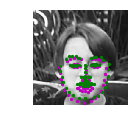

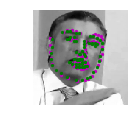

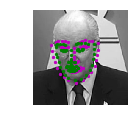

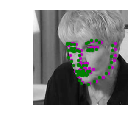

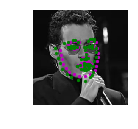

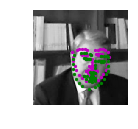

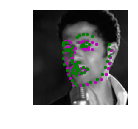

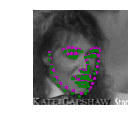

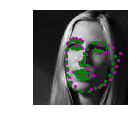

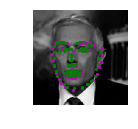

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Optimization: Adam and Loss Function: MSELoss. The reason to use this method are because Adam is slow and know to be the current best optimizer. According to my knowledge I assume there are no major outlier in the dataset therefore I used MSELoss.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I did not looked into many different architecture since namishnet reference given in the chapter was enough to get to know about the FKP. Therefore I used architecture which similar to namish net but also did some adding and removing of layer since the model was taking longer time than expected. Yes, to avoid overfitting I added 4 MaxPooling Layer  and 4 dropout layer with increasing dropout value from 10% to 30%. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Number of epochs and batch size training were experimental. I noticed the amount of loss and accuracy after batches and epochs. So, when I saw the satisfying results I went with this specific combination only.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.21936375 -0.22182265 -0.15824814  0.08497197 -0.17645504]
 [ 0.06892438 -0.23862353 -0.21537404  0.08722416  0.1414419 ]
 [ 0.02435074 -0.13301104 -0.25306335  0.02597637  0.12716724]
 [ 0.11772092 -0.12607546  0.08868194  0.00197301 -0.16460444]
 [-0.05280602 -0.09475273  0.14004186 -0.01145385 -0.15103556]]
(5, 5)


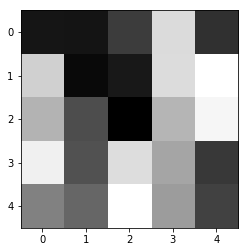

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(224, 224)


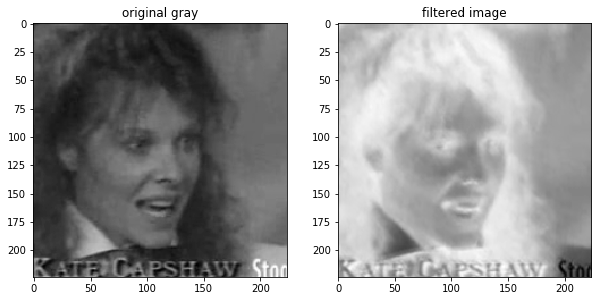

In [21]:

##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
#import numpy as np

%matplotlib inline
imgNo= 7
myImage = np.squeeze(test_images[imgNo].data)
myImage = myImage.numpy()  
print(myImage.shape)
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
myFilter=w[filter_index][0]
filtered_image = cv2.filter2D(myImage, -1, myFilter)

#plt.imshow(filtered_image, cmap='gray')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('original gray')
ax1.imshow(myImage, cmap='gray')

ax2.set_title('filtered image')
ax2.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I think it blurs it out

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!